
# Shared rides with pricing - Delft 

 ### Choice Function (Deterministic):
 `pool_price.py`
 * Pickup Distance: distance from driver initial position to the first pickup point
 * Travel Distance: distance from driver's initial position to the drop off point of the last passenger
 * Operating Cost: This include all the expenses
 * Profit: Driver revenue to serve the request
            
 
  ### KPI:
   
   * Profit of Individual driver
   * Profit of all the drivers
   * No.of rejected rides
   * U - PAX (Utility) 
  
   ### TBD- Choice Function (Probablistic):
  
  * choice logic to be applied inside `pool_price.py` 
  * P(R)= exp(beta * Profit_R)/ sum_all the rides( exp(beta * Profit_R)
 



In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging

import pandas as pd
import ExMAS


## Pricing for Delft, Netherlands

In [3]:
params = get_config('../../data/config/delft.json')  # load configuration

params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 10# reuqests (and passengers)
params.nV = 10# vehicles

## Parameters for ExMAS

In [4]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.5
params.shareability.comm_rate = 0.2

inData = load_G(inData, params)  # load network graph 

inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 


07-02-23 18:15:30-INFO-Initializing pairwise trip shareability between 10 and 10 trips.
07-02-23 18:15:30-INFO-creating combinations
07-02-23 18:15:30-INFO-90	 nR*(nR-1)
07-02-23 18:15:30-INFO-Reduction of feasible pairs by 91.11%
07-02-23 18:15:30-INFO-Degree 2 	Completed
07-02-23 18:15:30-INFO-trips to extend at degree 2 : 19
07-02-23 18:15:31-INFO-At degree 2 feasible extensions found out of 1 searched
07-02-23 18:15:31-INFO-Degree 3 	Completed
07-02-23 18:15:31-INFO-trips to extend at degree 3 : 1
07-02-23 18:15:31-INFO-At degree 3 feasible extensions found out of 0 searched
07-02-23 18:15:31-INFO-Degree 4 	Completed
07-02-23 18:15:31-INFO-Max degree reached 4
07-02-23 18:15:31-INFO-Trips still possible to extend at degree 4 : 0


In [5]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

07-02-23 18:15:31-INFO-Matching 10 trips to 30 rides in order to min u_pax
07-02-23 18:15:31-INFO-Problem solution: Optimal. 
Total costs for single trips:             51 
reduced by matching to:                   47


In [6]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],8.40950,454,1,[8.4095],"[0, 454]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1851699236, 1584013869]","[None, 0, 0]",node time req_id od 0 ...,454,4.54,6.82050,1.36410,5.45640
1,[1],6.48400,350,1,[6.484],"[32, 350]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44763127, 44839599]","[None, 1, 1]",node time req_id od 0 NaN...,350,3.50,5.25900,1.05180,4.20720
2,[2],3.71850,201,1,[3.7185],"[42, 201]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44829654, 1435362503]","[None, 2, 2]",node time req_id od 0 ...,201,2.01,3.01500,0.60300,2.41200
3,[3],7.32900,396,1,[7.329],"[46, 396]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44708877, 44814384]","[None, 3, 3]",node time req_id od 0 NaN...,396,3.96,5.94300,1.18860,4.75440
4,[4],3.91250,211,1,[3.9125],"[48, 211]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1402734947, 1571092666]","[None, 4, 4]",node time req_id od 0 ...,211,2.11,3.17400,0.63480,2.53920
5,[5],5.18000,280,1,[5.18],"[129, 280]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0,"[None, 1608998306, 1576745685]","[None, 5, 5]",node time req_id od 0 ...,280,2.80,4.20000,0.84000,3.36000
6,[6],4.63250,250,1,[4.6325],"[135, 250]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,"[None, 44863340, 4217813223]","[None, 6, 6]",node time req_id od 0 ...,250,2.50,3.75750,0.75150,3.00600
7,[7],4.57700,247,1,[4.577],"[163, 247]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0,"[None, 1584013869, 1571087701]","[None, 7, 7]",node time req_id od 0 ...,247,2.47,3.71250,0.74250,2.97000
8,[8],4.99950,270,1,[4.9995],"[227, 270]",[8],[8],1,8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,"[None, 970525520, 3581094285]","[None, 8, 8]",node time req_id od 0 ...,270,2.70,4.05450,0.81090,3.24360
9,[9],2.48350,134,1,[2.4835],"[310, 134]",[9],[9],1,9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44753491, 1474883280]","[None, 9, 9]",node time req_id od 0 ...,134,1.34,2.01450,0.40290,1.61160


## Simulation with MaaSSim 

07-02-23 18:15:34-INFO-Matching 10 trips to 30 rides in order to min u_pax
07-02-23 18:15:34-INFO-Problem solution: Optimal. 
Total costs for single trips:             51 
reduced by matching to:                   47
07-02-23 18:15:35-WARNING-Setting up 0.1h simulation at 2023-02-07 18:12:35 for 10 vehicles and 10 passengers in Delft, Netherlands
07-02-23 18:15:35-CRITICAL-this is request 0 with [0, 10, 11, 21, 22] available rides.
07-02-23 18:15:35-CRITICAL-ride 0 available [1]
07-02-23 18:15:35-CRITICAL-ride 10 available [1, 0]
07-02-23 18:15:35-CRITICAL-ride 11 available [1, 0]
07-02-23 18:15:35-CRITICAL-ride 21 available [1, 0]
07-02-23 18:15:35-CRITICAL-ride 22 available [1, 0]
07-02-23 18:15:35-CRITICAL-this is reuqest 0 with [0, 10, 11, 21, 22] still available rides.
07-02-23 18:15:35-CRITICAL-vehicle 1 has 5 choices
07-02-23 18:15:35-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 0 of degree 1, with travellers [0].
07-02-23 18:15:35-CRITICAL-this is request 1 with

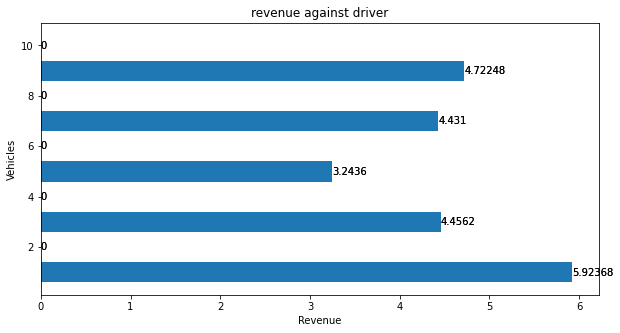

In [7]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

In [8]:
inData.vehicles.head(10)

,pos,event,shift_start,shift_end,platform,expected_income
veh,,,,,,
1,1584013869,driverEvent.ENDS_SHIFT,0,86400,0,NaN
2,44845271,driverEvent.ENDS_SHIFT,0,86400,0,NaN
3,44814384,driverEvent.ENDS_SHIFT,0,86400,0,NaN
4,4883670378,driverEvent.ENDS_SHIFT,0,86400,0,NaN
5,3581094285,driverEvent.ENDS_SHIFT,0,86400,0,NaN
6,44855162,driverEvent.ENDS_SHIFT,0,86400,0,NaN
7,1576745685,driverEvent.ENDS_SHIFT,0,86400,0,NaN
8,44882305,driverEvent.ENDS_SHIFT,0,86400,0,NaN
9,44839599,driverEvent.ENDS_SHIFT,0,86400,0,NaN


In [9]:
pd.DataFrame(sim.vehs[1].myrides)


,veh,pos,t,event,paxes
0,1,1.833104e+09,0.0,STARTS_DAY,[]
1,1,1.833104e+09,0.0,OPENS_APP,[]
2,1,1.833104e+09,0.0,RECEIVES_REQUEST,[]
3,1,1.833104e+09,15.0,ACCEPTS_REQUEST,[]
4,1,1.833104e+09,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,1.833104e+09,170.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,1,1.851699e+09,422.0,ARRIVES_AT_PICKUP,[]
7,1,1.851699e+09,422.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,1.851699e+09,452.0,DEPARTS_FROM_PICKUP,[0]
9,1,4.486334e+07,660.0,ARRIVES_AT_PICKUP,[0]


In [10]:
sim.res[0].pax_exp


,ACCEPTS_OFFER,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,MEETS_DRIVER_AT_PICKUP,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,
0,15.0,738.0,20.0,30.0,287.0,100.0,0.0,10.0,0,0,0,0,0,0,738.0,387.0,55.0
1,15.0,365.0,19.0,30.0,327.0,1.0,32.0,10.0,0,0,0,0,0,0,365.0,328.0,55.0
2,15.0,294.0,20.0,30.0,68.0,52.0,42.0,10.0,0,0,0,0,0,0,294.0,120.0,55.0
3,15.0,491.0,20.0,30.0,56.0,143.0,46.0,10.0,0,0,0,0,0,0,491.0,199.0,55.0
4,15.0,315.0,35.0,30.0,130.0,32.0,1.0,10.0,0,0,0,0,0,0,315.0,162.0,55.0
5,15.0,507.0,1.0,30.0,13.0,19.0,129.0,10.0,0,0,0,0,0,0,507.0,32.0,55.0
6,15.0,250.0,35.0,30.0,490.0,0.0,120.0,10.0,0,0,0,0,0,0,250.0,490.0,55.0
7,15.0,247.0,35.0,30.0,16.0,129.0,19.0,10.0,0,0,0,0,0,0,247.0,145.0,55.0
8,15.0,282.0,35.0,30.0,171.0,42.0,170.0,10.0,0,0,0,0,0,0,282.0,213.0,55.0


In [24]:
sim.res[0].veh_exp

,nRIDES,nREJECTED,OUT,STARTS_DAY,OPENS_APP,RECEIVES_REQUEST,ACCEPTS_REQUEST,REJECTS_REQUEST,IS_ACCEPTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,...,REPOSITIONED,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT,TRAVEL,WAIT,CRUISE,OPERATIONS,IDLE,PAX_KM,REVENUE
veh,,,,,,,,,,,,,,,,,,,,,
1,2.0,0.0,False,0,0,0.0,15.0,0,166.0,0,...,0,0,6216.0,558.0,0,544.0,241.0,4873.0,8.378,5.72880
2,1.0,0.0,False,0,0,294.0,15.0,0,20.0,0,...,0,0,6927.0,100.0,0,173.0,65.0,6589.0,1.004,1.20480
3,0.0,0.0,False,0,0,146.0,0.0,0,0.0,0,...,0,0,7413.0,0.0,0,0.0,0.0,7413.0,0.000,0.00000
4,0.0,0.0,False,0,0,0.0,0.0,0,0.0,0,...,0,0,7559.0,0.0,0,0.0,0.0,7559.0,0.000,0.00000
5,2.0,0.0,False,0,0,89.0,15.0,0,136.0,0,...,0,0,6406.0,578.0,0,275.0,211.0,5342.0,7.459,6.26556
6,0.0,0.0,False,0,0,325.0,15.0,0,20.0,0,...,0,0,0.0,0.0,0,0.0,35.0,-35.0,2.471,0.00000
7,0.0,0.0,False,0,0,0.0,0.0,0,0.0,0,...,0,0,7559.0,0.0,0,0.0,0.0,7559.0,0.000,0.00000
8,2.0,0.0,False,0,0,14.0,15.0,0,55.0,0,...,0,0,6699.0,567.0,0,149.0,130.0,5853.0,6.400,5.37600
9,1.0,0.0,False,0,0,230.0,15.0,0,20.0,0,...,0,0,7029.0,165.0,0,70.0,65.0,6729.0,1.659,1.99080


In [25]:
sim.res[0].all_kpi

22.571159999999995

In [26]:
from MaaSSim.driver import VehicleAgent, driverEvent
import pandas as pd
pd.DataFrame([[s,s.name,s.value] for s in driverEvent], 
             columns = ['status','name','value'])

,status,name,value
0,driverEvent.STARTS_DAY,STARTS_DAY,0
1,driverEvent.OPENS_APP,OPENS_APP,1
2,driverEvent.RECEIVES_REQUEST,RECEIVES_REQUEST,2
3,driverEvent.ACCEPTS_REQUEST,ACCEPTS_REQUEST,3
4,driverEvent.REJECTS_REQUEST,REJECTS_REQUEST,4
5,driverEvent.IS_ACCEPTED_BY_TRAVELLER,IS_ACCEPTED_BY_TRAVELLER,5
6,driverEvent.IS_REJECTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,6
7,driverEvent.ARRIVES_AT_PICKUP,ARRIVES_AT_PICKUP,7
8,driverEvent.MEETS_TRAVELLER_AT_PICKUP,MEETS_TRAVELLER_AT_PICKUP,8
9,driverEvent.DEPARTS_FROM_PICKUP,DEPARTS_FROM_PICKUP,9
